# BTS Tower Data Analysis


***
## 1. Data Extraction and Cleaning

In [ ]:
"""
Created on Sept 18 03:12:39 2017

@author: Aamir
"""

### 1.1 Import Libraries

In [114]:
%matplotlib inline
import os
import scipy.io
import numpy as np
import pandas as pd
from math import log10, floor
from datetime import datetime

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14,9]

In [4]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### 1.2 Import and select relevant data 

In [20]:
temp1 = pd.read_excel("rstats_tp.xlsx")

In [21]:
temp2 = pd.read_excel("rstatsx.xls")

In [22]:
temp1.shape, temp2.shape

((12651, 26), (15638, 17))

Clean the column names.

In [31]:
temp1.columns = ['SNo', 'DevID', 'RCli', 'RIpAddress', 'SigQty', 'Alarms',
       'FLevelR', 'FLevelUS', 'FVolume', 'Temp0', 'Temp1', 'BatBank0',
       'BatBank1', 'CP', 'GenOut', 'CT0', 'CT1', 'DCPower', 'DCEnergy',
       'GenRunTime', 'CPOutTime', 'OnBatTime', 'SysDT', 'TCUDT',
       'RawPkt', 'DataLoss']

In [38]:
temp2.columns = ['SNo', 'RIpAddress', 'RStatsSNo', 'Alarms', 'VaRms',
       'VbRms', 'VcRms', 'IaRms', 'IbRms', 'IcRms', 'Freq', 'Pf', 'ActPower',
       'AppPower', 'ReactPower', 'Energy', 'serial']

In [73]:
temp1.dtypes

SNo                    int64
DevID                 object
RCli                 float64
RIpAddress            object
SigQty                 int64
Alarms                 int64
FLevelR                int64
FLevelUS               int64
FVolume                int64
Temp0                float64
Temp1                float64
BatBank0             float64
BatBank1             float64
CP                     int64
GenOut                 int64
CT0                  float64
CT1                  float64
DCPower                int64
DCEnergy               int64
GenRunTime             int64
CPOutTime              int64
OnBatTime              int64
SysDT         datetime64[ns]
TCUDT                float64
RawPkt                object
DataLoss             float64
dtype: object

In [74]:
temp2.dtypes

SNo             int64
RIpAddress     object
RStatsSNo       int64
Alarms          int64
VaRms           int64
VbRms           int64
VcRms           int64
IaRms         float64
IbRms         float64
IcRms         float64
Freq          float64
Pf            float64
ActPower        int64
AppPower        int64
ReactPower      int64
Energy          int64
serial          int64
dtype: object

In [40]:
temp1.describe()

,SNo,RCli,SigQty,Alarms,FLevelR,FLevelUS,FVolume,Temp0,Temp1,BatBank0,...,GenOut,CT0,CT1,DCPower,DCEnergy,GenRunTime,CPOutTime,OnBatTime,TCUDT,DataLoss
count,1.265100e+04,7.002000e+03,12651.000000,1.265100e+04,12651.000000,12651.0,12651.000000,12651.000000,12651.000000,12651.000000,...,12651.000000,12651.000000,12651.000000,12651.000000,1.265100e+04,12651.000000,12651.000000,12651.000000,12650.000000,12650.0
mean,9.936403e+07,5.342436e+11,93.109636,5.658960e+06,559.495376,0.0,1169.766422,52.502948,45.047427,10.180073,...,11.090428,0.188546,2.138614,179.944589,4.540824e+07,262.732669,1901.173267,1646.467552,674.689881,0.0
std,1.290804e+04,4.560093e+11,3.816864,1.705954e+07,388.382166,0.0,1207.768221,42.631776,47.296037,15.293413,...,43.556949,0.375251,5.900616,264.574598,5.430981e+07,391.222940,2411.459154,2026.644796,471.755527,0.0
min,9.934710e+07,9.234100e+04,70.000000,2.457900e+04,94.000000,0.0,39.000000,9.200000,-46.600000,0.000000,...,1.000000,0.100000,-30.700000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
25%,9.935258e+07,9.234100e+04,90.000000,2.457900e+04,226.000000,0.0,143.000000,13.100000,6.900000,0.000000,...,2.000000,0.100000,0.300000,0.000000,0.000000e+00,0.000000,122.000000,107.000000,229.000000,0.0
50%,9.935704e+07,9.234197e+11,96.000000,1.507331e+06,266.000000,0.0,173.000000,18.600000,10.700000,12.400000,...,2.000000,0.100000,3.200000,178.000000,2.866795e+07,63.000000,720.000000,720.000000,580.000000,0.0
75%,9.937732e+07,9.234197e+11,96.000000,1.507843e+06,935.000000,0.0,2430.000000,99.900000,99.900000,13.500000,...,2.000000,0.100000,4.000000,237.000000,5.736597e+07,473.000000,2579.000000,2106.000000,1145.750000,0.0
max,9.938048e+07,9.234197e+11,96.000000,1.085015e+08,1142.000000,0.0,2915.000000,99.900000,99.900000,70.900000,...,240.000000,14.100000,79.400000,2353.000000,1.569432e+08,984.000000,7114.000000,6141.000000,1440.000000,0.0


In [41]:
temp2.describe()

,SNo,RStatsSNo,Alarms,VaRms,VbRms,VcRms,IaRms,IbRms,IcRms,Freq,Pf,ActPower,AppPower,ReactPower,Energy,serial
count,1.563800e+04,1.563800e+04,15638.0,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,1.563800e+04,15638.0,15638.0,15638.000000,15638.00000
mean,8.260991e+07,9.912169e+07,51455.0,104.302596,108.354777,112.552564,90.389877,94.613953,98.303440,56.072496,3.948855,2.955878e+03,0.0,0.0,208709.360468,7819.50000
std,1.790278e+04,7.928970e+05,0.0,11.328306,12.552530,13.329911,118.501345,125.995373,131.976355,197.863874,7.710886,1.948064e+04,0.0,0.0,163544.004697,4514.44609
min,8.257831e+07,0.000000e+00,51455.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,1.00000
25%,8.259450e+07,9.911260e+07,51455.0,105.000000,110.000000,112.000000,0.000000,0.000000,0.000000,49.700000,0.000000,0.000000e+00,0.0,0.0,10616.000000,3910.25000
50%,8.260906e+07,9.912717e+07,51455.0,106.000000,111.000000,116.000000,0.000000,0.000000,0.000000,49.900000,0.000000,0.000000e+00,0.0,0.0,206752.000000,7819.50000
75%,8.262492e+07,9.914305e+07,51455.0,107.000000,112.000000,117.000000,218.700000,232.000000,240.600000,50.000000,9.900000,7.840000e+03,0.0,0.0,376701.500000,11728.75000
max,8.264265e+07,9.916082e+07,51455.0,258.000000,130.000000,131.000000,328.100000,632.800000,999.900000,6553.500000,99.000000,2.373396e+06,0.0,0.0,500640.000000,15638.00000


### 1.3 Check missing values 

### 1.4 Convert to numeric columns 

### 1.5 Normalize Data

***
## 2. Exploratory Data Analysis

### Power Analysis

Active power anaylsis after removing one outlier. 

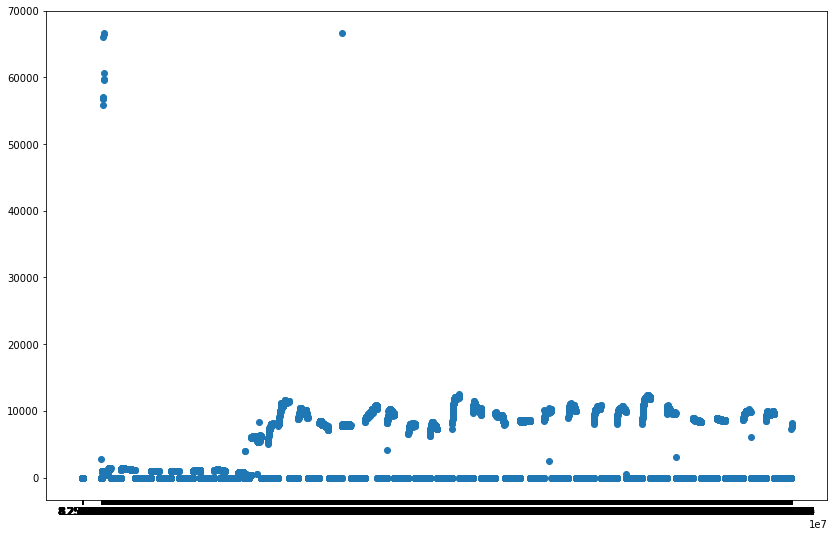

In [125]:
y=temp2[temp2.ActPower<100000]
plt.scatter(y.SNo,y.ActPower);
plt.xticks(y.SNo);

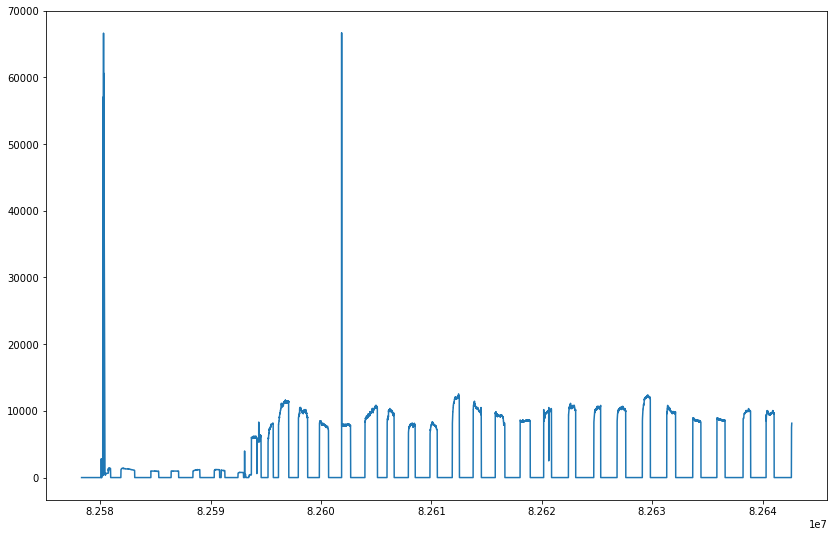

In [115]:
plt.plot(y.SNo,y.ActPower);

Energy consumption

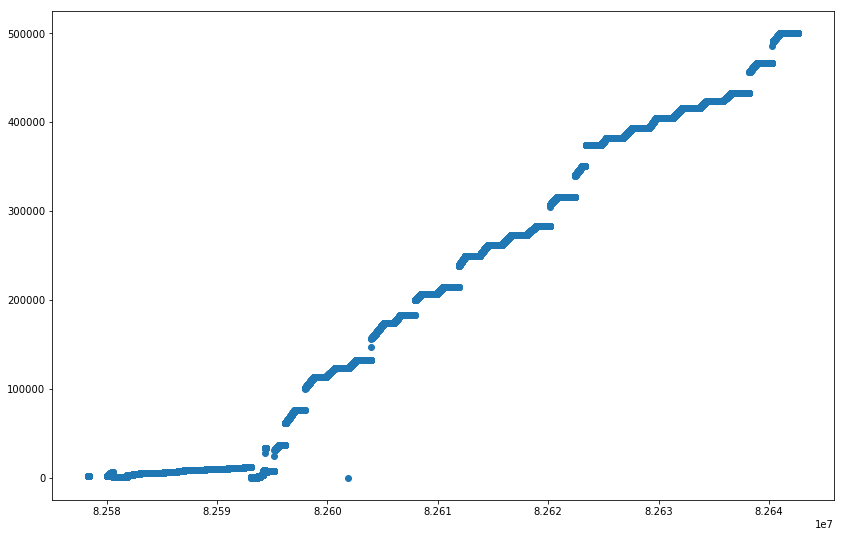

In [117]:
plt.scatter(temp2.SNo, temp2.Energy);

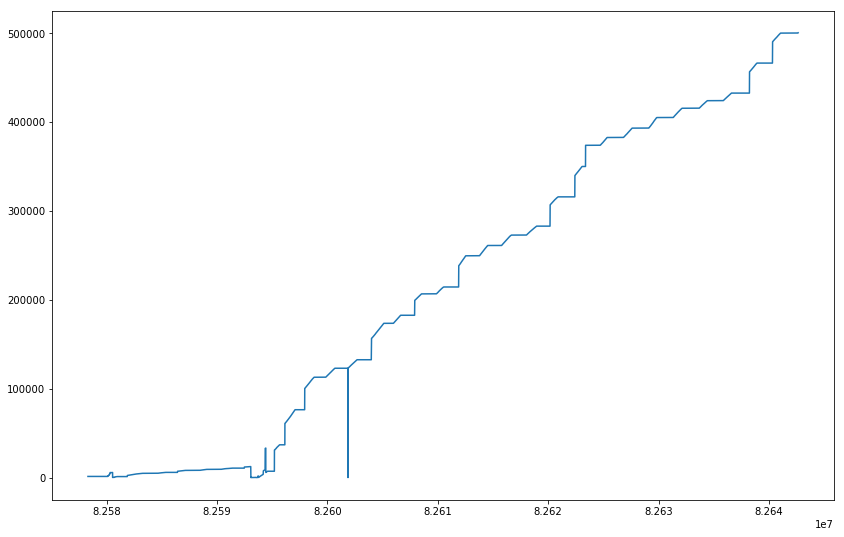

In [118]:
plt.plot(temp2.SNo, temp2.Energy);

Plotting Current

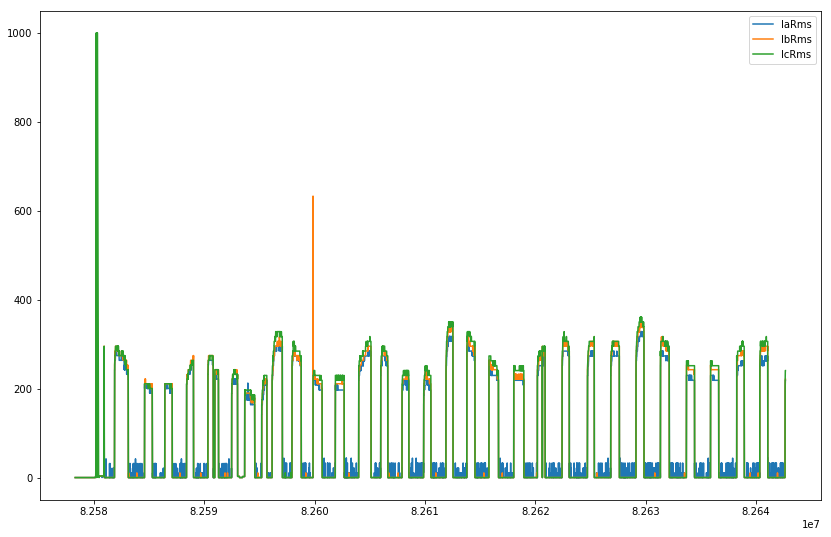

In [121]:
plt.plot(temp2.SNo, temp2.IaRms)
plt.plot(temp2.SNo, temp2.IbRms)
plt.plot(temp2.SNo, temp2.IcRms)
plt.legend(['IaRms', 'IbRms', 'IcRms'], loc='upper right')

Plotting Voltage

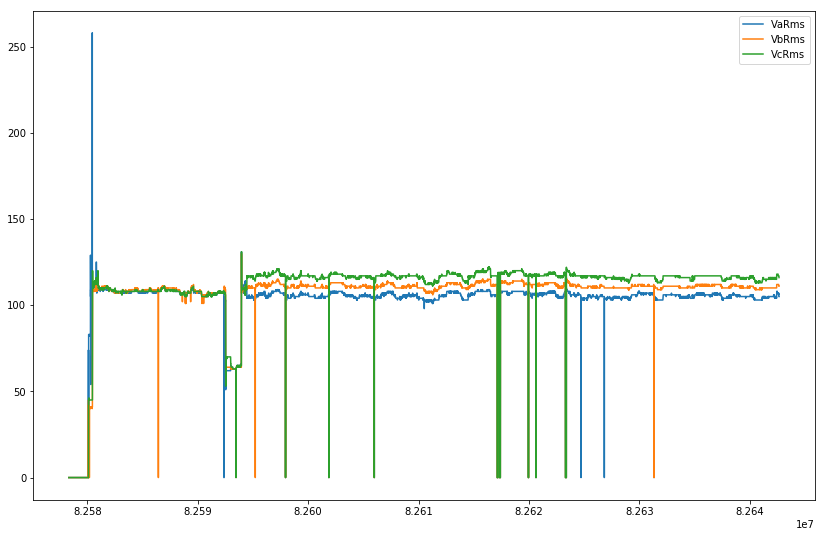

In [122]:
plt.plot(temp2.SNo, temp2.VaRms)
plt.plot(temp2.SNo, temp2.VbRms)
plt.plot(temp2.SNo, temp2.VcRms)
plt.legend(['VaRms', 'VbRms', 'VcRms'], loc='upper right')

***
## 3. Train and Evaluate the Model

### XGBoost MODEL

### XGBoost Setup

In [240]:
# Specify the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(Z_X)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [241]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

model1 = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:2.63927	valid-rmse:2.63198
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.37537	valid-rmse:2.36882
[2]	train-rmse:2.13787	valid-rmse:2.13197
[3]	train-rmse:1.92411	valid-rmse:1.91881
[4]	train-rmse:1.73174	valid-rmse:1.72696
[5]	train-rmse:1.5586	valid-rmse:1.55431
[6]	train-rmse:1.40278	valid-rmse:1.39892
[7]	train-rmse:1.26254	valid-rmse:1.25908
[8]	train-rmse:1.13634	valid-rmse:1.13323
[9]	train-rmse:1.02275	valid-rmse:1.01997
[10]	train-rmse:0.920528	valid-rmse:0.918045
[11]	train-rmse:0.828535	valid-rmse:0.82631
[12]	train-rmse:0.745739	valid-rmse:0.743755
[13]	train-rmse:0.671231	valid-rmse:0.669462
[14]	train-rmse:0.604177	valid-rmse:0.602606
[15]	train-rmse:0.543833	valid-rmse:0.542436
[16]	train-rmse:0.489533	valid-rmse:0.488295
[17]	train-rmse:0.440663	valid-rmse:0.439574
[18]	train-rmse:0.396689	valid-rmse:0.39574
[19]	train-rmse:0.35712	valid-rms

[179]	train-rmse:0.007069	valid-rmse:0.009407
[180]	train-rmse:0.007035	valid-rmse:0.009379
[181]	train-rmse:0.007029	valid-rmse:0.009372
[182]	train-rmse:0.007024	valid-rmse:0.009376
[183]	train-rmse:0.007007	valid-rmse:0.009377
[184]	train-rmse:0.006998	valid-rmse:0.009376
[185]	train-rmse:0.006976	valid-rmse:0.009351
[186]	train-rmse:0.006955	valid-rmse:0.00933
[187]	train-rmse:0.006947	valid-rmse:0.009323
[188]	train-rmse:0.006937	valid-rmse:0.009317
[189]	train-rmse:0.006928	valid-rmse:0.00932
[190]	train-rmse:0.006896	valid-rmse:0.009273
[191]	train-rmse:0.006877	valid-rmse:0.009256
[192]	train-rmse:0.006871	valid-rmse:0.009264
[193]	train-rmse:0.006868	valid-rmse:0.009263
[194]	train-rmse:0.006858	valid-rmse:0.009248
[195]	train-rmse:0.006848	valid-rmse:0.009233
[196]	train-rmse:0.006834	valid-rmse:0.009219
[197]	train-rmse:0.006824	valid-rmse:0.009215
[198]	train-rmse:0.006806	valid-rmse:0.009194
[199]	train-rmse:0.006799	valid-rmse:0.009183
[200]	train-rmse:0.006792	valid-rmse

[358]	train-rmse:0.005228	valid-rmse:0.008026
[359]	train-rmse:0.005225	valid-rmse:0.008024
[360]	train-rmse:0.005221	valid-rmse:0.008026
[361]	train-rmse:0.005218	valid-rmse:0.008025
[362]	train-rmse:0.005199	valid-rmse:0.00801
[363]	train-rmse:0.005191	valid-rmse:0.008007
[364]	train-rmse:0.005184	valid-rmse:0.007998
[365]	train-rmse:0.00518	valid-rmse:0.007999
[366]	train-rmse:0.005163	valid-rmse:0.007986
[367]	train-rmse:0.005159	valid-rmse:0.007983
[368]	train-rmse:0.005156	valid-rmse:0.007982
[369]	train-rmse:0.005153	valid-rmse:0.007978
[370]	train-rmse:0.005149	valid-rmse:0.007978
[371]	train-rmse:0.005146	valid-rmse:0.007971
[372]	train-rmse:0.00514	valid-rmse:0.00797
[373]	train-rmse:0.005128	valid-rmse:0.007964
[374]	train-rmse:0.005125	valid-rmse:0.007965
[375]	train-rmse:0.005124	valid-rmse:0.007965
[376]	train-rmse:0.005102	valid-rmse:0.007937
[377]	train-rmse:0.005098	valid-rmse:0.007935
[378]	train-rmse:0.005096	valid-rmse:0.007937
[379]	train-rmse:0.005088	valid-rmse:0

### Train/Validation Set Evaluation 

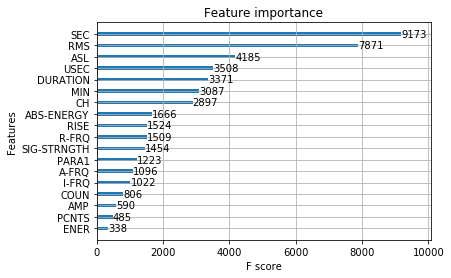

In [242]:
xgb.plot_importance(model1, height=0.3)

### Prediction

In [243]:
# evaluate the model
pred = model1.predict(dtest)

In [ ]:
pred = np.exp(pred) - 1

In [251]:
len(pred), len(Z_y)

(68534, 68534)

In [252]:
pred

array([  5.17074299,   3.13505983,   2.94549942, ...,  53.54247665,
        54.07151794,  53.72103882], dtype=float32)

In [265]:
# fit model no training data
model2 = xgb.XGBClassifier()
model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [262]:
# make predictions for test data
Z_h = model2.predict(Z_X)
Z_h

array([1, 1, 1, ..., 4, 4, 4])

In [256]:
predictions = [round(value) for value in Z_pred]

In [263]:
np.mean(Z_h == Z_y)

0.59357399247089038

In [473]:
result["DAMAGE"] = predictions

In [474]:
result.to_excel("resultTest.xlsx")

In [264]:
# evaluate predictions
accuracy = accuracy_score(Z_y, Z_h)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.36%


### RandomTreeClassifier MODEL

### Check feature importance

In [266]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X,y)

In [267]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

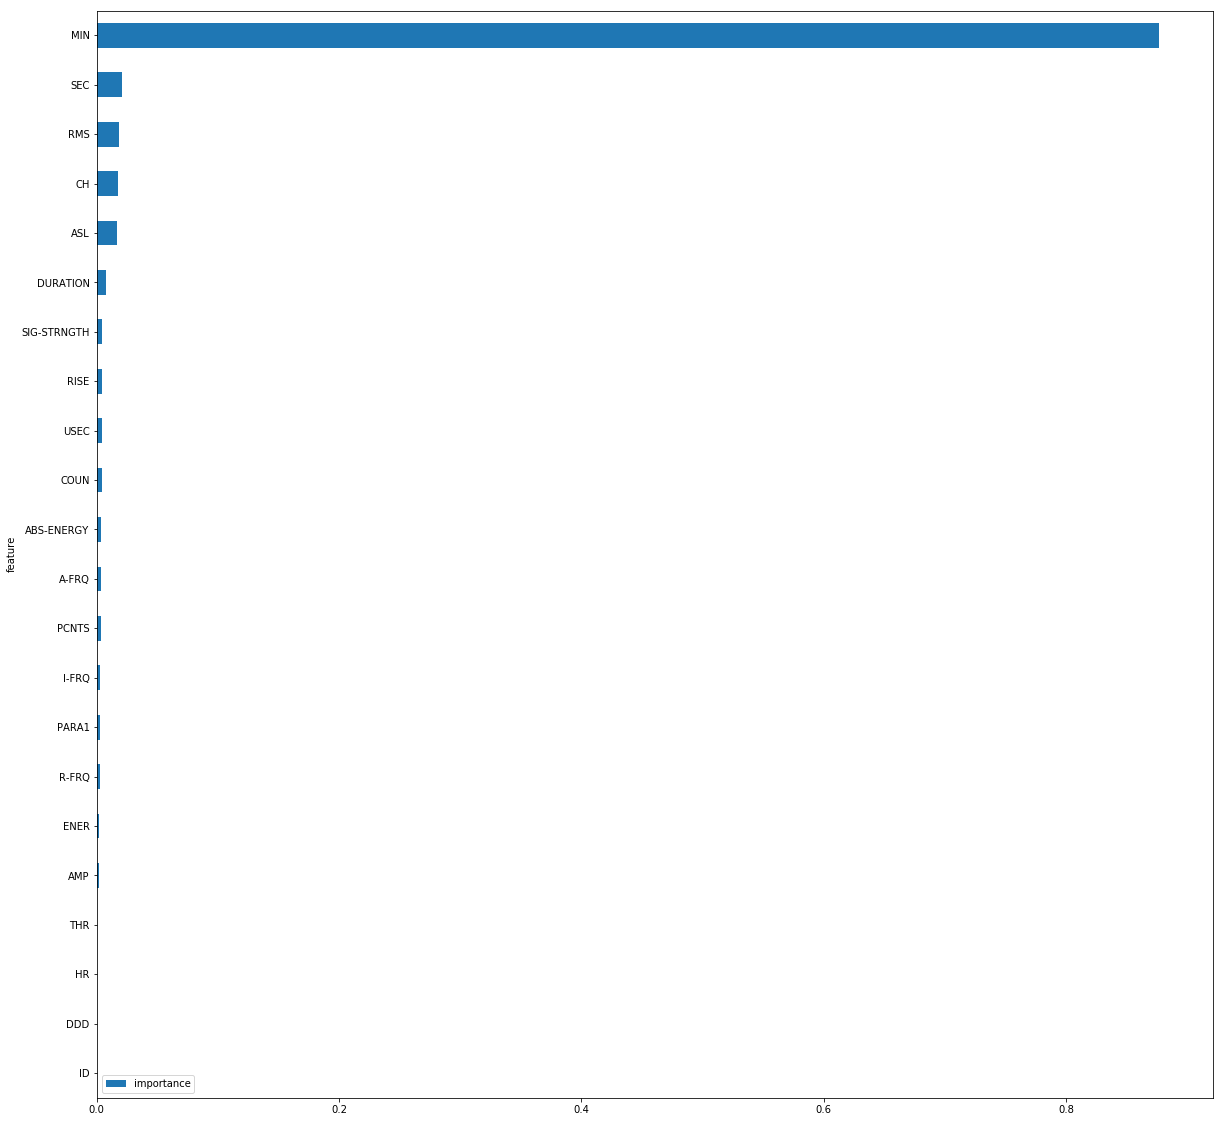

In [268]:
features.plot(kind='barh', figsize=(20, 20))

### Hyperparameter tuning

In [273]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
                'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model3 = RandomForestClassifier(**parameters)
model3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [274]:
xval = cross_val_score(model, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

1.0

In [275]:
Z_h = model3.predict(Z_X)

In [277]:
np.mean(Z_h == Z_y)

0.57466367058686196

In [280]:
pd.DataFrame(Z_h, Z_y)

,0
DAMAGE,
1,3
1,3
1,3
1,3
1,3
1,3
1,3
1,3
1,3


***
## 4. Predict and Evaluate

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline